In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image
from collections import defaultdict
import pyamg


In [3]:
def get_maximum(A):
    init = A[0]
    for a in A[1:]:
        init = np.maximum(a, init)
    return init

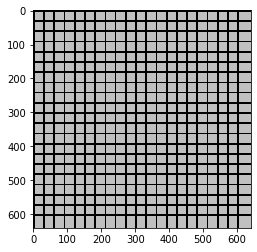

In [4]:
def draw_line(img, color, l, r, hor):
    if hor:
        img[l:r,:,color] = 0
    else:
        img[:,l:r,color] = 0

size = 640
O = np.ones((size, size))
img = cv2.merge([O, O, O]).astype("uint8")
img[img == 1] = 192
n = 30
for i in range(size // n):  
    l = 0 + n * i
    r = 5 + n * i
    for color in range(3):
        draw_line(img, color, l, r, True)
        draw_line(img, color, l, r, False)
        

plt.imshow(img)

In [7]:
def gen_circle(img , center, r):
    color = (255, 255, 255) 
    thickness = -1
    return cv2.circle(img, center, r, color, thickness) 

r = 80
centers = [(300,200), (300, 340) , (350, 280), (250, 280)]
circles = []
for center in centers:
    circles.append(gen_circle(np.copy(img) , center, r))

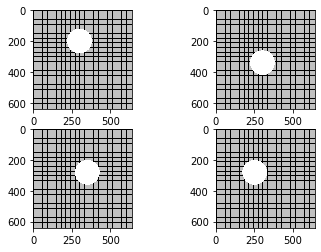

In [8]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(circles[0])
axarr[0,1].imshow(circles[1])
axarr[1,0].imshow(circles[2])
axarr[1,1].imshow(circles[3])

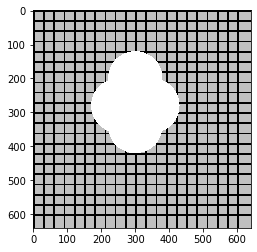

In [9]:
I_colors = defaultdict(list)
for I_k in circles:
    I = cv2.split(I_k)
    for color, value in enumerate(I):
        I_colors[color].append(value)

max_vals = []
for color in range(3):
    max_v = I_colors[color][0]
    for value in I_colors[color][1:]:
        max_v = np.maximum(max_v, value)
    max_vals.append(max_v)

I_max = cv2.merge(max_vals)
plt.imshow(I_max)

mb sobel

In [10]:
def stats(A):
    return A.dtype, A.shape, np.min(A), np.median(A), np.max(A)

## Calculate intensity gradients $G_k$ gradients of $I_k$. Sobel and numpy

In [11]:
G_sobel_x = []
G_sobel_y = []
G_np_x = []
G_np_y = []
# G = []
for circle in circles:
    
    sobelx = cv2.Sobel(circle,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(circle,cv2.CV_64F,0,1,ksize=5)
    G_sobel_x.append(sobelx)
    G_sobel_y.append(sobely)
    
    print(f"stats X: {stats(sobelx)}")
    print(f"stats Y: {stats(sobely)}")
    
    print("=" * 20)
   
    g_y, g_x, g_z = np.gradient(circle)
    G_np_x.append(g_x)
    G_np_y.append(g_y)    
    
    print(f"g_x : {stats(g_x)}")
    print(f"g_y : {stats(g_y)}")
    
    print("-" * 20)
    



stats X: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640, 3), -127.5, 0.0, 127.5)
g_y : (dtype('float64'), (640, 640, 3), -127.5, 0.0, 127.5)
--------------------
stats X: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640, 3), -127.5, 0.0, 127.5)
g_y : (dtype('float64'), (640, 640, 3), -127.5, 0.0, 127.5)
--------------------
stats X: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640, 3), -127.5, 0.0, 127.5)
g_y : (dtype('float64'), (640, 640, 3), -127.5, 0.0, 127.5)
--------------------
stats X: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
stats Y: (dtype('float64'), (640, 640, 3), -12240.0, 0.0, 12240.0)
g_x : (dtype('float64'), (640, 640, 3), -

## $G$ median of gradients ($G(x, y)= median_{k} (G_k(x,y))$). Sobel and numpy

In [12]:
G_sobel_median_x = np.median(G_sobel_x, axis=0)
G_sobel_median_y = np.median(G_sobel_y, axis=0)

G_np_median_x = np.median(G_np_x, axis=0)
G_np_median_y = np.median(G_np_y, axis=0)

In [13]:
print(f"sobel_x median: {stats(G_sobel_median_x)}")
print(f"numpy_x median: {stats(G_np_median_x)}")

sobel_x median: (dtype('float64'), (640, 640, 3), -9216.0, 0.0, 9216.0)
numpy_x median: (dtype('float64'), (640, 640, 3), -96.0, 0.0, 96.0)


## Poisson equation

### divergence of the vector field G

In [14]:
sobelx = cv2.Sobel(G_sobel_median_x,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(G_sobel_median_y,cv2.CV_64F,0,1,ksize=5)
div_G_sobel = sobelx + sobely

x_y, x_x, x_z = np.gradient(G_np_median_x)
y_y, y_x, y_z = np.gradient(G_np_median_y)
div_G_np = x_x + y_y

In [15]:
print(f"div_G_sobel: {stats(div_G_sobel)}")
print(f"div_G_np: {stats(div_G_np)}")

div_G_sobel: (dtype('float64'), (640, 640, 3), -756864.0, 0.0, 494071.5)
div_G_np: (dtype('float64'), (640, 640, 3), -96.0, 0.0, 79.875)


### Solver

In [16]:
def calc_R(alpha, I, I_max):
    return alpha * I + (1 - alpha) * I_max

In [17]:
def solve_poisson(shape, div_G):
    A = pyamg.gallery.poisson(shape, format='csr')  # 2D Poisson problem on 500x500 grid
    ml = pyamg.ruge_stuben_solver(A)                    # construct the multigrid hierarchy
    print(ml)                                           # print hierarchy information
    b = div_G.ravel()
    x = ml.solve(b, tol=1e-10)
    print("residual: ", np.linalg.norm(b-A*x)) 
    return x

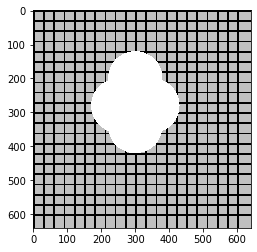

In [18]:
I_max = get_maximum(circles)
plt.imshow(I_max)

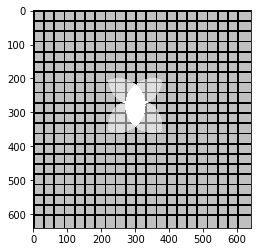

In [19]:
I_median = np.median(circles, axis=0)
plt.imshow(I_median.astype('uint8'))

#### Full img

In [20]:
shape = (size, size, 3)

##### Sobel

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.340
Grid Complexity:      1.573
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      1228800      7774720 [42.73%]
    1       614400      9195526 [50.54%]
    2        70226       950332 [ 5.22%]
    3        14201       194797 [ 1.07%]
    4         3614        53394 [ 0.29%]
    5         1334        18348 [ 0.10%]
    6          505         5855 [ 0.03%]
    7          182         1620 [ 0.01%]
    8           65          407 [ 0.00%]
    9           22          108 [ 0.00%]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


residual:  0.0012263174410186385
ans: (dtype('float64'), (640, 640, 3), -632205.2493605288, -21176.226035116983, 676821.6981950612)
Wall time: 4.46 s


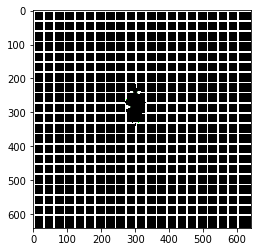

In [21]:
%%time
ans_sobel = solve_poisson(shape, div_G_sobel).reshape(-1, size, 3)
plt.imshow(ans_sobel)
print(f"ans: {stats(ans_sobel)}")

#### Numpy

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.340
Grid Complexity:      1.573
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      1228800      7774720 [42.73%]
    1       614400      9195526 [50.54%]
    2        70226       950332 [ 5.22%]
    3        14201       194797 [ 1.07%]
    4         3614        53394 [ 0.29%]
    5         1334        18348 [ 0.10%]
    6          505         5855 [ 0.03%]
    7          182         1620 [ 0.01%]
    8           65          407 [ 0.00%]
    9           22          108 [ 0.00%]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


residual:  2.5648399040232548e-06
ans: (dtype('float64'), (640, 640, 3), -69.50702044715798, -1.3110876030455452, 47.1200377571974)
Wall time: 4.21 s


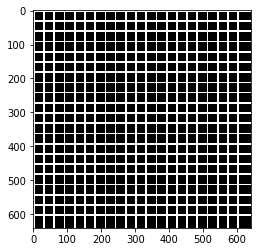

In [19]:
%%time
ans_np = solve_poisson(shape, div_G_np).reshape(-1, size, 3)
plt.imshow(ans_np)
print(f"ans: {stats(ans_np)}")

#### By color img

In [20]:
shape = (size, size)

#### Sobel

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  0.007012695747917715


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  0.007012695747917715


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


residual:  0.007012695747917715
Sobel by colors ans: (dtype('float64'), (640, 640, 3), -3140722.3041833118, -912925.1457602183, 2725807.721718561)
Wall time: 4.89 s


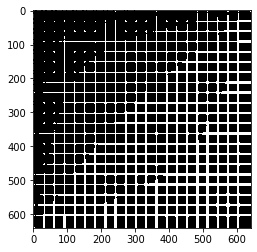

In [21]:
%%time
colors_sobel = cv2.split(div_G_sobel)
ans = []
for color in colors_sobel:
    ans.append(solve_poisson(shape, color).reshape(-1, size))
ans = cv2.merge(ans)
print(f"Sobel by colors ans: {stats(ans)}")
plt.imshow(ans)

In [22]:
ans_sobel, A = solve_poisson(shape, div_G_sobel)

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]



ValueError: dimension mismatch

In [24]:
gray = cv2.cvtColor(circles[0], cv2.COLOR_BGR2GRAY)
stats(gray)

(dtype('uint8'), (640, 640), 0, 192.0, 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


stats: (dtype('float64'), (640, 640, 3), -676789.2066221926, 28165.327582393948, 632205.2493605288)


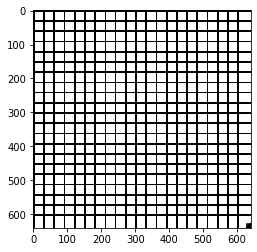

In [21]:
print(f"stats: {stats(-1*ans_sobel)}")
plt.imshow(-1*ans_sobel)

test: (dtype('float64'), (640, 640, 3), 0.0, 135.97082245790574, 255.0)


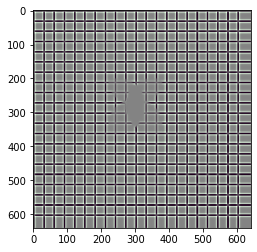

In [22]:
test = np.copy(-1 * ans_sobel)
test -= np.min(test)
test /= np.max(test) / 255
test[test > 255] = 255
print(f"test: {stats(test)}")
test = test.astype('uint8')
plt.imshow(test)

R stats: (dtype('float64'), (640, 640, 3), 0.0, 143.4, 249.6)


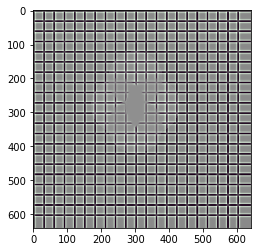

In [25]:
R = calc_R(0.9, test, I_max)
print(f"R stats: {stats(R)}")
plt.imshow(R.astype('uint8'))